In [24]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from umap import UMAP
from sklearn.manifold import TSNE

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [37]:
# Read data
origin = pd.read_csv('data/playground-series-s3e13/trainn.csv')

train = pd.read_csv('data/playground-series-s3e13/train.csv').drop(columns='id')
test = pd.read_csv('data/playground-series-s3e13/test.csv').drop(columns='id')

train['is_generated'] = 1
test['is_generated'] = 1
origin['is_generated'] = 0

origin.prognosis = origin.prognosis.str.replace(' ', '_')
train.prognosis = train.prognosis.str.replace(' ', '_')

In [38]:
print(f'[INFO] Shapes:'
      f'\n origin: {origin.shape}'
      f'\n train: {train.shape}'
      f'\n test: {test.shape}\n')

print(f'[INFO] Any missing values:'
      f'\n origin: {origin.isna().any().any()}'
      f'\n train: {train.isna().any().any()}'
      f'\n test: {test.isna().any().any()}')

[INFO] Shapes:
 origin: (252, 66)
 train: (707, 66)
 test: (303, 65)

[INFO] Any missing values:
 origin: False
 train: False
 test: False


In [39]:
full_train = pd.concat([train, origin], axis=0).reset_index(drop=True)

In [40]:
train.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis,is_generated
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease,1
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis,1
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease,1
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever,1


In [41]:
train.columns


Index(['sudden_fever', 'headache', 'mouth_bleed', 'nose_bleed', 'muscle_pain',
       'joint_pain', 'vomiting', 'rash', 'diarrhea', 'hypotension',
       'pleural_effusion', 'ascites', 'gastro_bleeding', 'swelling', 'nausea',
       'chills', 'myalgia', 'digestion_trouble', 'fatigue', 'skin_lesions',
       'stomach_pain', 'orbital_pain', 'neck_pain', 'weakness', 'back_pain',
       'weight_loss', 'gum_bleed', 'jaundice', 'coma', 'diziness',
       'inflammation', 'red_eyes', 'loss_of_appetite', 'urination_loss',
       'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin',
       'yellow_eyes', 'facial_distortion', 'microcephaly', 'rigor',
       'bitter_tongue', 'convulsion', 'anemia', 'cocacola_urine',
       'hypoglycemia', 'prostraction', 'hyperpyrexia', 'stiff_neck',
       'irritability', 'confusion', 'tremor', 'paralysis', 'lymph_swells',
       'breathing_restriction', 'toe_inflammation', 'finger_inflammation',
       'lips_irritation', 'itchiness', 'ulcers',

In [42]:
# Create figure
fig = px.histogram(train['prognosis'],
                   template='plotly_dark',
                   color_discrete_sequence = ['#1192AA'])



# Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Frequency",
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Train Prognosis Distribution",
        'y':0.95,
        'x':0.5
        }
    )

# Display
fig.show()

In [43]:
# Create figure
fig = px.histogram(origin['prognosis'],
                   template='plotly_dark',
                   color_discrete_sequence = ['#1192AA'])



# Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Frequency",
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Origin Prognosis Distribution",
        'y':0.95,
        'x':0.5
        }
    )

# Display
fig.show()

In [45]:
# Create figure
fig = px.imshow(train.drop(columns='prognosis').corr(), template='plotly_dark')

# Set Title and x/y axis labels
fig.update_layout(
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Train Dataset Correlation",
        'y':0.95,
        'x':0.49
        }
    )

# Display
fig.show() 

In [46]:
# Create figure
fig = px.imshow(origin.drop(columns='prognosis').corr(), template='plotly_dark')

# Set Title and x/y axis labels
fig.update_layout(
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Original Dataset Correlation",
        'y':0.95,
        'x':0.49
        }
    )

# Display
fig.show() 

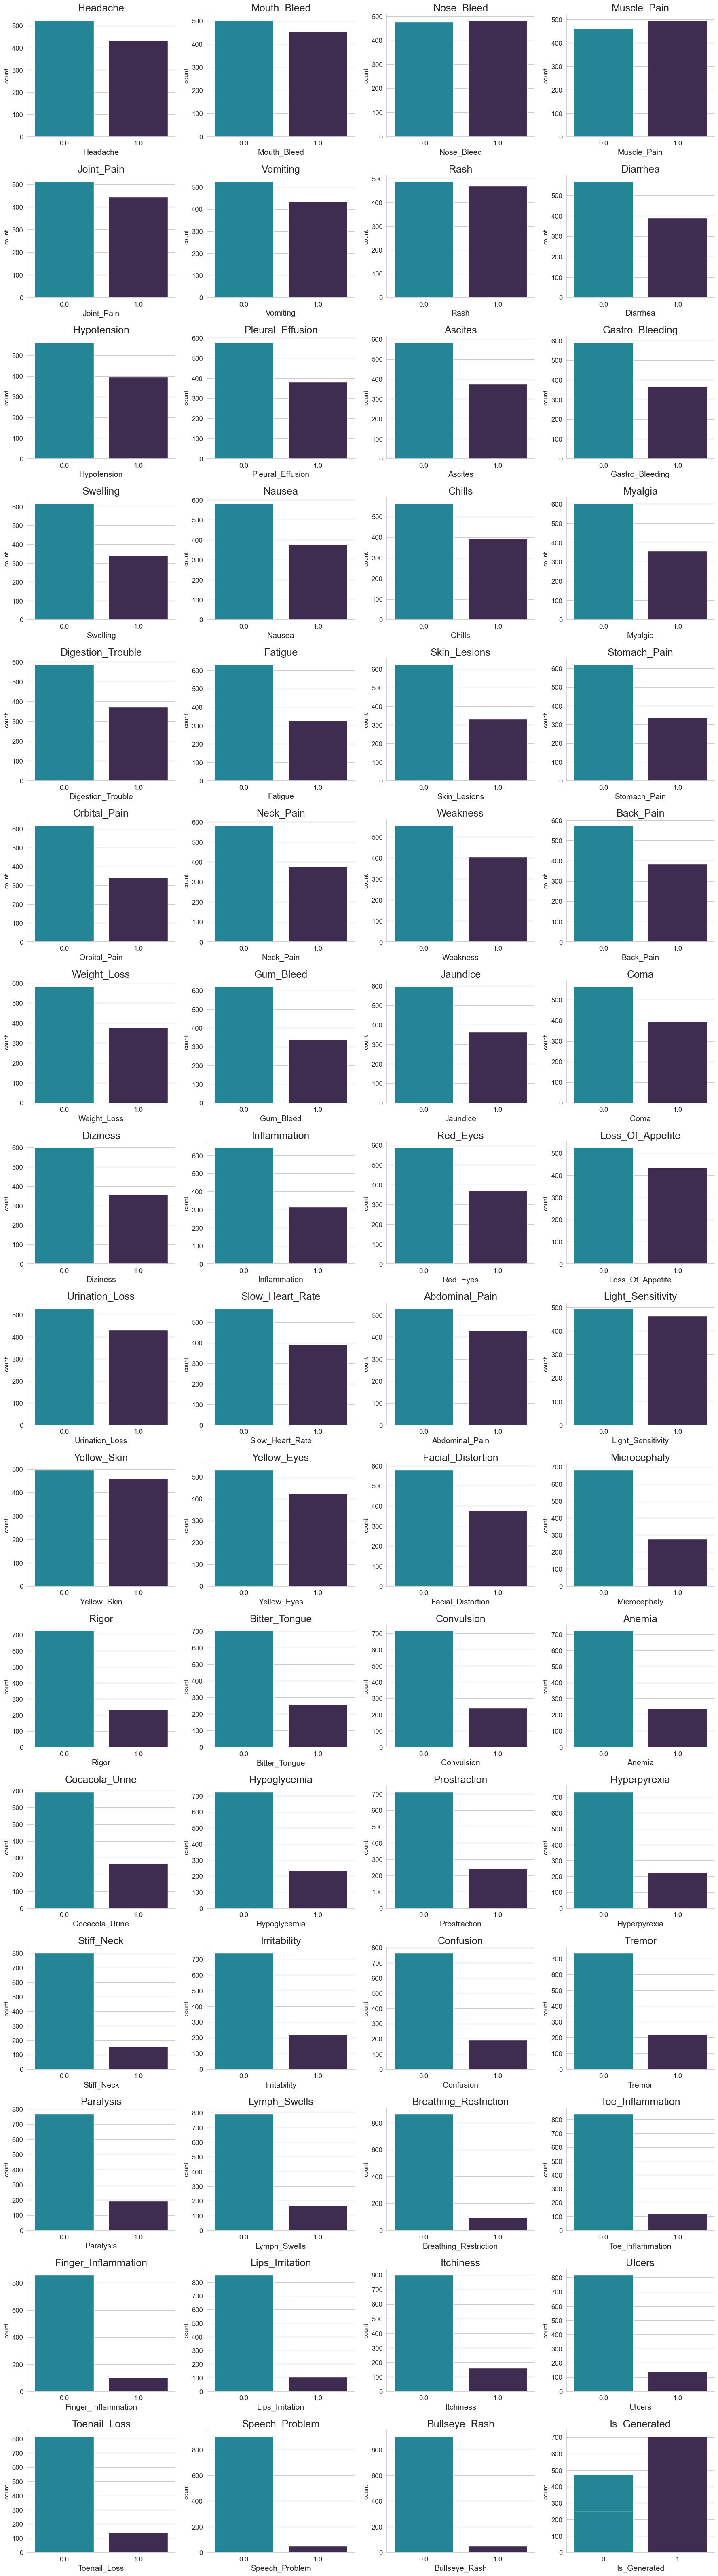

In [47]:
def plot_countplots(df, num_cols, palette):
    num_rows = (len(test.columns) - 1) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4*num_rows))
    sns.set(font_scale=1.2, style='white')

    for i, col_name in enumerate(test.columns):
        #if (col_name != 'is_generated') or (col_name != target_col):
        ax = axes[(i-1) // num_cols, (i-1) % num_cols]
        sns.countplot(data=df, x=col_name, ax=ax, palette=palette)
        ax.set_title(f'{col_name.title()}', fontsize=18)
        ax.set_xlabel(col_name.title(), fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        sns.despine()

    plt.tight_layout()
    plt.show()
    
my_palette = ['#1192AA','#3E2756']
plot_countplots(full_train, 4, my_palette)

In [48]:
# Create a dictionary mapping each disease name to a corresponding integer value
target_map = {
    'Lyme_disease': 0,
    'Tungiasis': 1,
    'Zika': 2,
    'Rift_Valley_fever': 3,
    'West_Nile_fever': 4,
    'Malaria': 5,
    'Chikungunya': 6,
    'Plague': 7,
    'Dengue': 8,
    'Yellow_Fever': 9,
    'Japanese_encephalitis': 10
}
swapped_map = {v: k for k, v in target_map.items()}
full_train['prognosis'] = full_train['prognosis'].replace(target_map).astype(int)

# Concatenate train and original dataframes, and prepare train and test sets
X_train = full_train.drop(['prognosis'], axis=1).reset_index(drop=True).astype(int)
y_train = full_train['prognosis'].reset_index(drop=True)
X_test = test.reset_index(drop=True).astype(int)
X_train_ori, X_test_ori = X_train.copy(), X_test.copy()

# # Add dimension_reduction Featrues
# umap_n_components = 5
# decomp = Decomp(n_components=umap_n_components, method='umap', scaler_method=None)
# umap_train = decomp.dimension_reduction(X_train).reset_index(drop=True)
# umap_test = decomp.transform(X_test).reset_index(drop=True)
# print(f'  --> UMAP(n_components={umap_n_components})')

# # Concat Data
# X_train = pd.concat([X_train_ori, umap_train], axis=1).reset_index(drop=True)
# X_test = pd.concat([X_test_ori, umap_test], axis=1).reset_index(drop=True)
# # X_train, X_test = X_train_ori.copy(), X_test_ori.copy()

print("")
print(f"X_train shape :{X_train.shape}")
print(f"y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del train, test, full_train, origin

X_train.head(5)


X_train shape :(959, 65)
y_train shape :(959,)
X_test shape :(303, 65)


,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,is_generated
0,1,1,0,1,1,1,1,0,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
3,0,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1


In [23]:
submission.to_csv('rf_v1.csv',index=False)